In [1]:
import collections
import csv
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle

## Loading the data...

In [2]:
representatives_df = pd.read_csv("../../../data/00_raw_data/twitter_representatives_handles_final.csv")

### Loading retweet networks

In [3]:
# loading the networks since we need to get the
# indegree of each representative
# Reading data
basepath = '../../../data/03_backbone_nets'

before_data = pd.read_csv(os.path.join(basepath, 'before_campaign_backbone.csv'))
during_data = pd.read_csv(os.path.join(basepath, 'electoral_campaign_backbone.csv'))
after_data = pd.read_csv(os.path.join(basepath, 'after_elections_backbone.csv'))

# Forcing the conversion to string
before_data['source'] = before_data['source'].astype(str)
before_data['target'] = before_data['target'].astype(str)
during_data['source'] = during_data['source'].astype(str)
during_data['target'] = during_data['target'].astype(str)
after_data['source'] = after_data['source'].astype(str)
after_data['target'] = after_data['target'].astype(str)

# Shapes
print("Before data has shape: ", before_data.shape)
print("During data has shape: ", during_data.shape)
print("After data has shape: ", after_data.shape)

Before data has shape:  (38209, 4)
During data has shape:  (56953, 4)
After data has shape:  (42864, 4)


In [4]:
# Creating graphs
before_graph = nx.from_pandas_edgelist(before_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
during_graph = nx.from_pandas_edgelist(during_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
after_graph = nx.from_pandas_edgelist(after_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())

# Some basic stats
print("Before graph has: ", before_graph.number_of_nodes(), " nodes and ", before_graph.number_of_edges(), " edges")
print("During graph has: ", during_graph.number_of_nodes(), " nodes and ", during_graph.number_of_edges(), " edges")
print("After graph has: ", after_graph.number_of_nodes(), " nodes and ", after_graph.number_of_edges(), " edges")

Before graph has:  12008  nodes and  38209  edges
During graph has:  18150  nodes and  56953  edges
After graph has:  15943  nodes and  42864  edges


### Loading community data

In [7]:
output_path = f"../../../data/04_communities"

before_comms = pickle.load(open(os.path.join(output_path, 'before_comms.pickle'), 'rb'))
during_comms = pickle.load(open(os.path.join(output_path, 'during_comms.pickle'), 'rb'))
after_comms = pickle.load(open(os.path.join(output_path, 'after_comms.pickle'), 'rb'))

## Reducing the number of communities

In [8]:
print("Before graph has: ", len(before_comms), " communities")
print("During graph has: ", len(during_comms), " communities")
print("After graph has: ", len(after_comms), " communities")

Before graph has:  57  communities
During graph has:  438  communities
After graph has:  428  communities


In [9]:
# size check
before_comm_sizes = [len(comm) for comm in before_comms]
during_comm_sizes = [len(comm) for comm in during_comms]
after_comm_sizes = [len(comm) for comm in after_comms]

In [10]:
print(np.quantile(before_comm_sizes, [.8, .9, .95, .97, .99]))
print(np.quantile(during_comm_sizes, [.8, .9, .95, .97, .99]))
print(np.quantile(after_comm_sizes, [.8, .9, .95, .97, .99]))

[  15.6   217.6  1887.4  2214.44 2671.32]
[   3.      5.     10.     21.34 1797.66]
[   3.      5.     10.     33.57 1799.06]


In [11]:
n_comm_b = len([comm for comm in before_comms if len(comm) >= 20])
n_comm_d = len([comm for comm in during_comms if len(comm) >= 20])
n_comm_a = len([comm for comm in after_comms if len(comm) >= 20])

print(n_comm_b, n_comm_d, n_comm_a)

11 14 16


In [12]:
before_comms_red = [comm for comm in before_comms if len(comm) >= 20]
during_comms_red = [comm for comm in during_comms if len(comm) >= 20]
after_comms_red = [comm for comm in after_comms if len(comm) >= 20]

## Community analysis - Parties

### Community entropy (in terms of parties/coalitions)

In [13]:
representatives_df.head(5);

In [14]:
parties, ids = representatives_df["Party"], representatives_df["ids"]

In [15]:
#get unique parties
unique_parties = list(set(parties))
print(len(unique_parties), unique_parties)

8 ['Forza Italia', 'Lega', 'Azione - Italia Viva', 'Alleanza Verdi Sinistra', 'Movimento 5s', 'Partito Democratico', "Fratelli d'Italia", 'Noi moderati']


In [16]:
# dict with key ids and parties as values
id2party = {ids[i]:parties[i] for i in range(0, len(ids))}

In [17]:
def eval_parties_composition(comm, id2party, count=False, weighted=False, retweet_net=None):
    to_return = []

    for user in comm:
        if user in id2party:
            if weighted:
                if retweet_net is None:
                    print('Need access to the network to get the indegree')
                    return None
                else:
                    indeg = retweet_net.in_degree(user, weight='weight')
                    to_return.append([id2party[user]]*max(indeg, 1))
            else:
                to_return.append(id2party[user])

    if count:
        return collections.Counter(to_return)

    if weighted:
        to_return = [party for weighted_party in to_return for party in weighted_party]

    return to_return

#### Get the party composition per community across the three periods

In [18]:
before_comms = before_comms_red
during_comms = during_comms_red
after_comms = after_comms_red

In [19]:
before_community_composition = {}
during_community_composition = {}
after_community_composition = {}

for index in range(0, len(before_comms)):
    before_community_composition[index] = eval_parties_composition(before_comms[index], id2party)

for index in range(0, len(during_comms)):
    during_community_composition[index] = eval_parties_composition(during_comms[index], id2party)

for index in range(0, len(after_comms)):
    after_community_composition[index] = eval_parties_composition(after_comms[index], id2party)


before_community_composition_w = {}
during_community_composition_w = {}
after_community_composition_w = {}

weighted = True

for index in range(0, len(before_comms)):
    before_community_composition_w[index] = \
        eval_parties_composition(before_comms[index], id2party, weighted=weighted, retweet_net=before_graph)

for index in range(0, len(during_comms)):
    during_community_composition_w[index] = \
        eval_parties_composition(during_comms[index], id2party, weighted=weighted, retweet_net=during_graph)

for index in range(0, len(after_comms)):
    after_community_composition_w[index] = \
        eval_parties_composition(after_comms[index], id2party, weighted=weighted, retweet_net=after_graph)

In [26]:
# output_path = f"../../../results/SNAM/communities/comms_composition"

# #store the comms
# pickle.dump(before_community_composition, open(os.path.join(output_path, 'before_community_composition.pickle'), 'wb'))
# pickle.dump(during_community_composition, open(os.path.join(output_path, 'during_community_composition.pickle'), 'wb'))
# pickle.dump(after_community_composition, open(os.path.join(output_path, 'after_community_composition.pickle'), 'wb'))

In [22]:
during_community_composition;

In [23]:
# get the different parties in each period
before_parties = {party for comm_comp in before_community_composition.values() for party in comm_comp}
during_parties = {party for comm_comp in during_community_composition.values() for party in comm_comp}
after_parties = {party for comm_comp in after_community_composition.values() for party in comm_comp}  

len(before_parties), len(during_parties), len(after_parties)

(7, 8, 8)

In [24]:
before_parties, during_parties, after_parties

({'Alleanza Verdi Sinistra',
  'Azione - Italia Viva',
  'Forza Italia',
  "Fratelli d'Italia",
  'Lega',
  'Movimento 5s',
  'Partito Democratico'},
 {'Alleanza Verdi Sinistra',
  'Azione - Italia Viva',
  'Forza Italia',
  "Fratelli d'Italia",
  'Lega',
  'Movimento 5s',
  'Noi moderati',
  'Partito Democratico'},
 {'Alleanza Verdi Sinistra',
  'Azione - Italia Viva',
  'Forza Italia',
  "Fratelli d'Italia",
  'Lega',
  'Movimento 5s',
  'Noi moderati',
  'Partito Democratico'})

In [32]:
# output_path = f"../../../results/SNAM/communities/comms_composition"

# #store the comms
# pickle.dump(before_parties, open(os.path.join(output_path, 'before_parties.pickle'), 'wb'))
# pickle.dump(during_parties, open(os.path.join(output_path, 'during_parties.pickle'), 'wb'))
# pickle.dump(after_parties, open(os.path.join(output_path, 'after_parties.pickle'), 'wb'))

##### Plot the community composition

In [25]:
def get_values_to_plot(parties_per_period, comm_composition_per_period):
    ys = {}
    m = np.zeros([len(parties_per_period), len(comm_composition_per_period)])
    
    for (i, party) in enumerate(parties_per_period):
        ys[party] = []
        for (j, comm_comp) in enumerate(comm_composition_per_period):
            cnt = collections.Counter(comm_comp)
            if party in cnt:
                ys[party].append(cnt[party])
                m[i, j] = cnt[party]
            else:
                ys[party].append(0)
                m[i, j] = 0
    
    return ys, m.sum(axis=0)

In [37]:
def plot_party_dist_per_comm(ax, xs, parties_per_period, comm_composition_per_period):
    ys, tot_per_comm = get_values_to_plot(parties_per_period, comm_composition_per_period)
    # ys_val = list(ys.values()) / tot_per_comm
    sorted_parties = sorted(parties_per_period)

    #ys_val = [ys[party] for party in sorted_parties] / tot_per_comm
    num = np.array([ys[party] for party in sorted_parties], dtype=float)
    den = tot_per_comm
    
    ys_val = np.divide(num, den, out=np.zeros_like(num), where=den!=0)

    ax.bar(xs, ys_val[0], bottom=0)
    bottom = ys_val[0]

    for i in range(1, len(parties_per_period)):
        ax.bar(xs, ys_val[i], bottom=bottom)
        bottom += ys_val[i]

    legend = sorted_parties #list(ys.keys())
    ax.legend(legend, loc='upper center', ncol=len(list(ys.keys())), bbox_to_anchor=(0.5, 1.2))

    ax.set_xlabel("Communities")
    ax.set_ylabel("Party distribution")

    return ys, tot_per_comm, ys_val

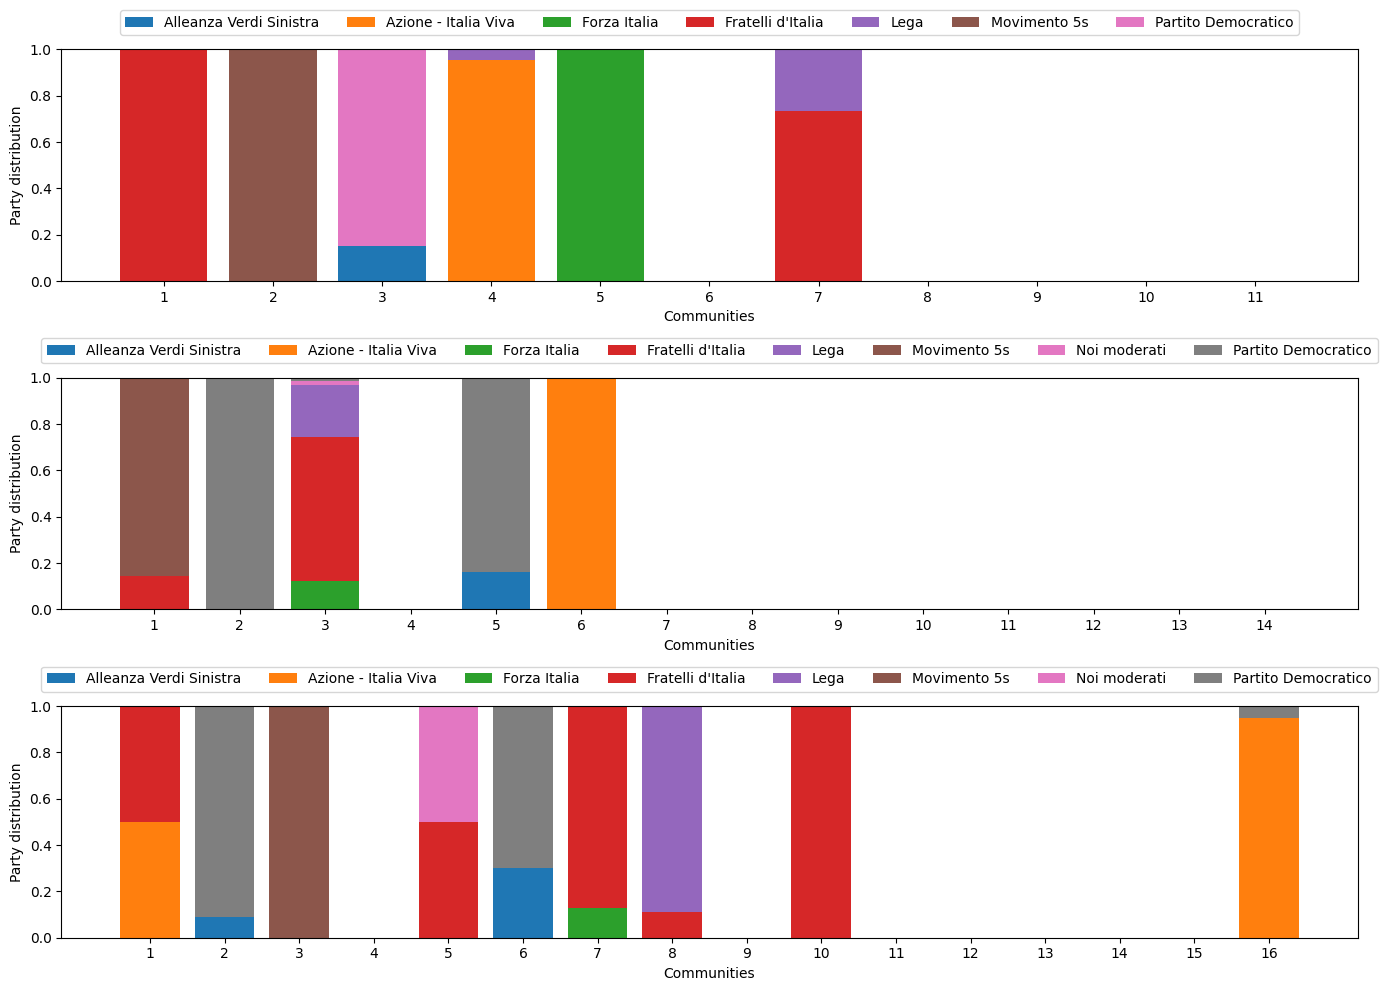

In [42]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

xs_b = [f"{i}" for i in range(1, len(before_comms)+1)]
xs_d = [f"{i}" for i in range(1, len(during_comms)+1)]
xs_a = [f"{i}" for i in range(1, len(after_comms)+1)]

# before 
ys_b, tot_per_comm_b, ys_val_b = plot_party_dist_per_comm(ax[0], xs_b, before_parties, before_community_composition.values())
# during
ys_d, tot_per_comm_d, ys_val_d = plot_party_dist_per_comm(ax[1], xs_d, during_parties, during_community_composition.values())
# after
ys_a, tot_per_comm_a, ys_val_a = plot_party_dist_per_comm(ax[2], xs_a, after_parties, after_community_composition.values())

fig.tight_layout()

In [80]:
# store data to plot in latex for the article
def compute_data_for_latex(ys, tot_per_comm):
    df = pd.DataFrame(ys)
    print(len(tot_per_comm))
    # add column with total number of representatives in the community
    df['tot'] = tot_per_comm
    # # divide by the total number of representatives in the community
    df = df.div(df['tot'], axis=0)
    # # add comm_id as column
    df['comm_id'] = range(1, len(df)+1)
    # # drop NaN
    df = df.dropna()

    return df


In [83]:
df_b = compute_data_for_latex(ys_b, tot_per_comm_b)
df_b.to_csv(os.path.join(output_path, 'before_community_comp_data.csv'), index=False)

df_d = compute_data_for_latex(ys_d, tot_per_comm_d)
df_d.to_csv(os.path.join(output_path, 'during_community_comp_data.csv'), index=False)

df_a = compute_data_for_latex(ys_a, tot_per_comm_a)
df_a.to_csv(os.path.join(output_path, 'after_community_comp_data.csv'), index=False)

11
14
16


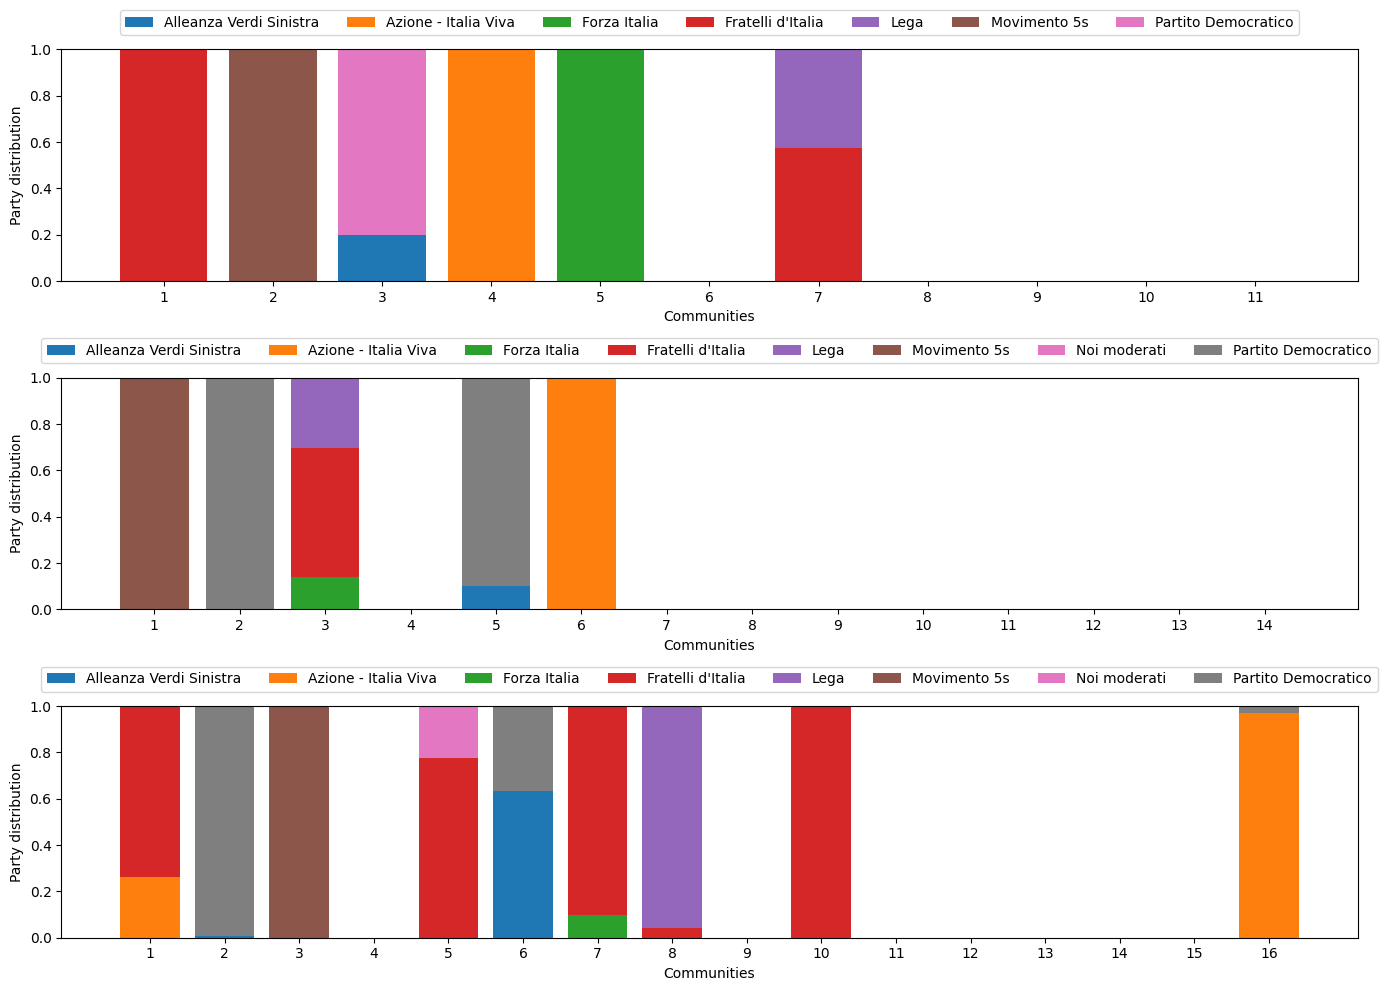

In [28]:
# weighted version where we take into account the indegree of each representative
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

xs_b = [f"{i}" for i in range(1, len(before_comms)+1)]
xs_d = [f"{i}" for i in range(1, len(during_comms)+1)]
xs_a = [f"{i}" for i in range(1, len(after_comms)+1)]

# before 
plot_party_dist_per_comm(ax[0], xs_b, before_parties, before_community_composition_w.values())
# during
plot_party_dist_per_comm(ax[1], xs_d, during_parties, during_community_composition_w.values())
# after
plot_party_dist_per_comm(ax[2], xs_a, after_parties, after_community_composition_w.values())

fig.tight_layout()

### Community analysis - Representatives

In [29]:
# we want to know which candidate is in which community
def find_candidate(comm, representatives_df):
    to_return = []
    ids_representatives = representatives_df["ids"].values

    for user in comm:
        if user in ids_representatives:
            candidate_name = representatives_df[representatives_df["ids"] == user]["Name"].values[0]
            candidate_party = representatives_df[representatives_df["ids"] == user]["Party"].values[0]
            to_return.append((candidate_name, candidate_party))

    return to_return

In [86]:
candidates_per_comm_before = {comm_id: find_candidate(comm, representatives_df) for comm_id, comm in enumerate(before_comms)}
candidates_per_comm_during = {comm_id: find_candidate(comm, representatives_df) for comm_id, comm in enumerate(during_comms)}
candidates_per_comm_after = {comm_id: find_candidate(comm, representatives_df) for comm_id, comm in enumerate(after_comms)}

In [53]:
# comm_comp = after_community_composition
# cands = candidates_per_comm_after

# for i in range(0, len(comm_comp)):
#     print(len(comm_comp[i]) == len(cands[i]))

In [87]:
candidates_per_comm_before

{0: [('Rotondi Gianfranco', "Fratelli d'Italia"),
  ('La Russa Ignazio', "Fratelli d'Italia")],
 1: [('Conte Giuseppe', 'Movimento 5s'),
  ('Raffa Angela', 'Movimento 5s'),
  ('Fontana Ilaria', 'Movimento 5s')],
 2: [('Letta Enrico', 'Partito Democratico'),
  ('Misiani Antonio', 'Partito Democratico'),
  ('Amendola Vincenzo', 'Partito Democratico'),
  ('Ascani Anna', 'Partito Democratico'),
  ('Fratoianni Nicola', 'Alleanza Verdi Sinistra'),
  ('Piccolotti Elisabetta', 'Alleanza Verdi Sinistra'),
  ('Braga Chiara', 'Partito Democratico'),
  ('Quartapelle Procopio Lia', 'Partito Democratico'),
  ('Bazoli Alfredo', 'Partito Democratico'),
  ('Evi Eleonora', 'Alleanza Verdi Sinistra'),
  ('Cottarelli Carlo', 'Partito Democratico'),
  ('Fassino Piero', 'Partito Democratico'),
  ('Scotto Arturo', 'Partito Democratico'),
  ('Vaccari Stefano', 'Partito Democratico'),
  ('Lorenzin Beatrice', 'Partito Democratico'),
  ('Irto Nicola', 'Partito Democratico'),
  ('Zingaretti Nicola', 'Partito Demo

In [88]:
candidates_per_comm_during

{0: [('Filini Francesco', "Fratelli d'Italia"),
  ('Conte Giuseppe', 'Movimento 5s'),
  ('Pirro Elisa', 'Movimento 5s'),
  ('Fontana Ilaria', 'Movimento 5s'),
  ('Costa Sergio', 'Movimento 5s'),
  ('Appendino Chiara', 'Movimento 5s'),
  ('Santilo Agostino', 'Movimento 5s')],
 1: [('Fornaro Federico', 'Partito Democratico'),
  ('Scotto Arturo', 'Partito Democratico'),
  ('Guerra Maria Cecilia', 'Partito Democratico')],
 2: [('Lupi Maurizio', 'Noi moderati'),
  ("Mule' Giorgio", 'Forza Italia'),
  ('Pella Roberto', 'Forza Italia'),
  ('Rotondi Gianfranco', "Fratelli d'Italia"),
  ('Cirielli Edmondo', "Fratelli d'Italia"),
  ('Fitto Raffaele', "Fratelli d'Italia"),
  ('Montaruli Augusta', "Fratelli d'Italia"),
  ('Pucciarelli Stefania', 'Lega'),
  ('Borghi Claudio', 'Lega'),
  ('Meloni Giorgia', "Fratelli d'Italia"),
  ('De Bertoldi Andrea', "Fratelli d'Italia"),
  ('Ravetto Laura', 'Lega'),
  ('Sasso Rossano', 'Lega'),
  ('Bergamini Deborah', 'Forza Italia'),
  ('Bitonci Massimo', 'Lega'

In [89]:
candidates_per_comm_after

{0: [('Rotondi Gianfranco', "Fratelli d'Italia"),
  ('Benzoni Fabrizio', 'Azione - Italia Viva')],
 1: [('Letta Enrico', 'Partito Democratico'),
  ('Ascani Anna', 'Partito Democratico'),
  ('Boldrini Laura', 'Partito Democratico'),
  ('Orfini Matteo', 'Partito Democratico'),
  ('Malpezzi Simona Flavia', 'Partito Democratico'),
  ('Soumahoro Aboubakar', 'Alleanza Verdi Sinistra'),
  ('Provenzano Giuseppe', 'Partito Democratico'),
  ('Borghi Enrico', 'Partito Democratico'),
  ('Zan Alessandro', 'Partito Democratico'),
  ('Zampa Sandra', 'Partito Democratico'),
  ('Fina Michele', 'Partito Democratico')],
 2: [('Conte Giuseppe', 'Movimento 5s'),
  ('Fontana Ilaria', 'Movimento 5s'),
  ('Nave Luigi', 'Movimento 5s'),
  ('Appendino Chiara', 'Movimento 5s'),
  ('Santilo Agostino', 'Movimento 5s')],
 3: [],
 4: [('Lupi Maurizio', 'Noi moderati'),
  ('Gardini Elisabetta', "Fratelli d'Italia")],
 5: [('Bonelli Angelo', 'Alleanza Verdi Sinistra'),
  ('Orlando Andrea', 'Partito Democratico'),
  ('

## Store communities' data

In [98]:
output_path = f'../../../data/04_communities'

# we store the following data for each communtity. For each user,
# - the user id
# - the community they belong to
# - the most common party in the community

In [91]:
party_acronyms = {
    'Alleanza Verdi Sinistra': 'AVS',
    'Azione - Italia Viva': 'Az-Iv',
    'Forza Italia': 'FI',
    "Fratelli d'Italia": 'FdI',
    'Lega': 'L',
    'Movimento 5s': 'M5s',
    'Noi moderati': 'NM',
    'Partito Democratico': 'PD'
}

In [92]:
def get_label(comm_comp):
    parties = list(set(comm_comp))
    parties_acr = [party_acronyms[party] for party in parties]
    label = ";".join(parties_acr) 
    return label

In [101]:
when = 'after' # during after
dict_comms = {
    'before': before_comms,
    'during': during_comms,
    'after': after_comms
}
dict_composition = {
    'before': before_community_composition,
    'during': during_community_composition,
    'after': after_community_composition
}

communities = dict_comms[when]
communities_composition = dict_composition[when]
fout = open(os.path.join(output_path, f'{when}_communities.csv'), 'w')

with fout:
    writer = csv.writer(fout)
    writer.writerow(['user_id', 'community_id', 'comm_label','most_common_party', 'all_parties'])

    for index in range(0, len(communities)):
        # get the community
        comm = communities[index]
        # get the parties in the community
        parties = communities_composition[index]

        if parties:
            # get the most common party
            most_common_party = collections.Counter(parties).most_common(1)[0][0]
        else:
            most_common_party = ""

        # get all parties
        parties = list(set(parties))
        parties_to_write = ";".join(parties)

        # comm_label
        comm_label = get_label(parties)

        print(f"Community {index}, {len(comm)} users, {comm_label} label, {len(parties)} parties, most common party: {most_common_party}")

        for user in comm:
            writer.writerow([user, index, comm_label, most_common_party, parties_to_write])

Community 0, 1418 users, Az-Iv;FdI label, 2 parties, most common party: Fratelli d'Italia
Community 1, 1940 users, AVS;PD label, 2 parties, most common party: Partito Democratico
Community 2, 2065 users, M5s label, 1 parties, most common party: Movimento 5s
Community 3, 33 users,  label, 0 parties, most common party: 
Community 4, 36 users, NM;FdI label, 2 parties, most common party: Noi moderati
Community 5, 421 users, AVS;PD label, 2 parties, most common party: Partito Democratico
Community 6, 2244 users, FI;FdI label, 2 parties, most common party: Fratelli d'Italia
Community 7, 3870 users, L;FdI label, 2 parties, most common party: Lega
Community 8, 94 users,  label, 0 parties, most common party: 
Community 9, 27 users, FdI label, 1 parties, most common party: Fratelli d'Italia
Community 10, 74 users,  label, 0 parties, most common party: 
Community 11, 67 users,  label, 0 parties, most common party: 
Community 12, 27 users,  label, 0 parties, most common party: 
Community 13, 49 us

In [84]:
# BEFORE
# Community 0, 406 users, 1 parties, most common party: Fratelli d'Italia
# Community 1, 2057 users, 1 parties, most common party: Movimento 5s
# Community 2, 1832 users, 2 parties, most common party: Partito Democratico
# Community 3, 2827 users, 2 parties, most common party: Azione - Italia Viva
# Community 4, 85 users, 1 parties, most common party: Forza Italia
# Community 5, 29 users, 0 parties, most common party: 
# Community 6, 1845 users, 2 parties, most common party: Fratelli d'Italia
# Community 7, 2549 users, 0 parties, most common party: 
# Community 8, 89 users, 0 parties, most common party: 
# Community 9, 92 users, 0 parties, most common party: 
# Community 10, 33 users, 0 parties, most common party: 

In [ ]:
# DURING
# Community 0, 2874 users, 2 parties, most common party: Movimento 5s
# Community 1, 478 users, 1 parties, most common party: Partito Democratico
# Community 2, 2568 users, 5 parties, most common party: Fratelli d'Italia
# Community 3, 23 users, 0 parties, most common party: 
# Community 4, 2700 users, 2 parties, most common party: Partito Democratico
# Community 5, 3942 users, 1 parties, most common party: Azione - Italia Viva
# Community 6, 22 users, 0 parties, most common party: 
# Community 7, 3205 users, 0 parties, most common party: 
# Community 8, 165 users, 0 parties, most common party: 
# Community 9, 40 users, 0 parties, most common party: 
# Community 10, 486 users, 0 parties, most common party: 
# Community 11, 216 users, 0 parties, most common party: 
# Community 12, 227 users, 0 parties, most common party: 
# Community 13, 46 users, 0 parties, most common party: 

In [ ]:
# AFTER
# Community 0, 1418 users, 2 parties, most common party: Azione - Italia Viva
# Community 1, 1940 users, 2 parties, most common party: Partito Democratico
# Community 2, 2065 users, 1 parties, most common party: Movimento 5s
# Community 3, 33 users, 0 parties, most common party: 
# Community 4, 36 users, 2 parties, most common party: Noi moderati
# Community 5, 421 users, 2 parties, most common party: Partito Democratico
# Community 6, 2244 users, 2 parties, most common party: Fratelli d'Italia
# Community 7, 3870 users, 2 parties, most common party: Lega
# Community 8, 94 users, 0 parties, most common party: 
# Community 9, 27 users, 1 parties, most common party: Fratelli d'Italia
# Community 10, 74 users, 0 parties, most common party: 
# Community 11, 67 users, 0 parties, most common party: 
# Community 12, 27 users, 0 parties, most common party: 
# Community 13, 49 users, 0 parties, most common party: 
# Community 14, 74 users, 0 parties, most common party: 
# Community 15, 2435 users, 2 parties, most common party: Azione - Italia Viva

In [106]:
# just to be sure, we store the data together
# (comm_id, comm, comm_composition)
# for each period

when = 'after' # during after
dict_comms = {
    'before': before_comms,
    'during': during_comms,
    'after': after_comms
}
dict_composition = {
    'before': before_community_composition,
    'during': during_community_composition,
    'after': after_community_composition
}

fout = f'../../../data/04_communities/{when}_communities_all_data.pickle'

communities = dict_comms[when]
communities_composition = dict_composition[when]

data_list = []

for index in range(0, len(communities)):
    # get the community
    comm = communities[index]
    # get the parties in the community
    parties = communities_composition[index]
    
    elem = (index, comm, parties)
    data_list.append(elem)

pickle.dump(data_list, open(fout, 'wb'))